In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import metrics 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#Loading the dataset
test_data = pd.read_csv('TargetData.csv')


#Print the first 5 rows of the dataframe.
test_data.head()

X = test_data.drop(["ID","SB","COL","Margin","Block","ROW"],axis = 1)
y = test_data.ROW #COL #SB

In [49]:
#post pruning
from sklearn.tree._tree import TREE_LEAF

def is_leaf(inner_tree, index):
    # Check whether node is leaf node
    return (inner_tree.children_left[index] == TREE_LEAF and 
            inner_tree.children_right[index] == TREE_LEAF)

def prune_index(inner_tree, decisions, index=0):
    # Start pruning from the bottom - if we start from the top, we might miss
    # nodes that become leaves during pruning.
    # Do not use this directly - use prune_duplicate_leaves instead.
    if not is_leaf(inner_tree, inner_tree.children_left[index]):
        prune_index(inner_tree, decisions, inner_tree.children_left[index])
    if not is_leaf(inner_tree, inner_tree.children_right[index]):
        prune_index(inner_tree, decisions, inner_tree.children_right[index])

    # Prune children if both children are leaves now and make the same decision:     
    if (is_leaf(inner_tree, inner_tree.children_left[index]) and
        is_leaf(inner_tree, inner_tree.children_right[index]) and
        (decisions[index] == decisions[inner_tree.children_left[index]]) and 
        (decisions[index] == decisions[inner_tree.children_right[index]])):
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
        ##print("Pruned {}".format(index))

def prune_duplicate_leaves(mdl):
    # Remove leaves if both 
    decisions = mdl.tree_.value.argmax(axis=2).flatten().tolist() # Decision for each node
    prune_index(mdl.tree_, decisions)

In [50]:
#importing train_test_split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/3,random_state=2, stratify=y)

from sklearn.tree import DecisionTreeClassifier

max_accuracy=0
best_depth=12
best_impurity_decrease=0.0001
best_weight_fraction_leaf=0.001
for DEPTH in range(12,21,1):
    dt = DecisionTreeClassifier(criterion='entropy',max_depth=DEPTH,random_state=0,min_impurity_decrease=0.0001,min_weight_fraction_leaf=0.001)
    dt.fit(X_train, y_train)
    #post_pruning
    prune_duplicate_leaves(dt)

    print(DEPTH,dt.score(X_test, y_test))
    if dt.score(X_test, y_test)>max_accuracy: 
        max_accuracy=dt.score(X_test, y_test)
        best_depth=DEPTH
        
for impurity_decrease in range(5,15,1):

    dt = DecisionTreeClassifier(criterion='entropy',max_depth=best_depth,random_state=0,min_impurity_decrease=impurity_decrease*0.00001,min_weight_fraction_leaf=0.001)
    dt.fit(X_train, y_train)
    #post_pruning
    prune_duplicate_leaves(dt)

    print(best_depth,impurity_decrease,dt.score(X_test, y_test))
    if dt.score(X_test, y_test)>max_accuracy: 
        max_accuracy=dt.score(X_test, y_test)
        best_impurity_decrease=impurity_decrease*0.00001
        
for weight_fraction_leaf in range(5,15,1):
    dt = DecisionTreeClassifier(criterion='entropy',max_depth=best_depth,random_state=0,min_impurity_decrease=best_impurity_decrease,min_weight_fraction_leaf=weight_fraction_leaf*0.0001)
    dt.fit(X_train, y_train)
    #post_pruning
    prune_duplicate_leaves(dt)

    print(best_depth,best_impurity_decrease,weight_fraction_leaf,dt.score(X_test, y_test))
    if dt.score(X_test, y_test)>max_accuracy: 
        max_accuracy=dt.score(X_test, y_test)
        best_weight_fraction_leaf=weight_fraction_leaf*0.0001

        
    

dt = DecisionTreeClassifier(criterion='entropy',max_depth=best_depth,random_state=0,min_impurity_decrease=best_impurity_decrease,min_weight_fraction_leaf=best_weight_fraction_leaf)
dt.fit(X_train, y_train)    

#post_pruning
prune_duplicate_leaves(dt)

print("selected depth: {:d}".format(best_depth))
print("selected best_impurity_decrease: {:.8f}".format(best_impurity_decrease))
print("selected best_weight_fraction_leaf: {:.8f}".format(best_weight_fraction_leaf))
print("Accuracy on training set: {:.3f}".format(dt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(dt.score(X_test, y_test)))

12 0.8195926285160039
13 0.8215324927255092
14 0.8205625606207565
15 0.8186226964112512
16 0.8205625606207565
17 0.8205625606207565
18 0.8205625606207565
19 0.8166828322017459
20 0.8186226964112512
13 5 0.8215324927255092
13 6 0.8215324927255092
13 7 0.8215324927255092
13 8 0.8215324927255092
13 9 0.8215324927255092
13 10 0.8215324927255092
13 11 0.8215324927255092
13 12 0.8215324927255092
13 13 0.8215324927255092
13 14 0.8215324927255092
13 0.0001 5 0.8176527643064986
13 0.0001 6 0.8176527643064986
13 0.0001 7 0.8176527643064986
13 0.0001 8 0.8176527643064986
13 0.0001 9 0.8176527643064986
13 0.0001 10 0.8215324927255092
13 0.0001 11 0.8215324927255092
13 0.0001 12 0.8215324927255092
13 0.0001 13 0.8215324927255092
13 0.0001 14 0.8215324927255092
selected depth: 13
selected best_impurity_decrease: 0.00010000
selected best_weight_fraction_leaf: 0.00100000
Accuracy on training set: 0.847
Accuracy on test set: 0.822


In [51]:
y_pred = dt.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix  

print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred)) 

[[646  47]
 [137 201]]
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       693
           1       0.81      0.59      0.69       338

   micro avg       0.82      0.82      0.82      1031
   macro avg       0.82      0.76      0.78      1031
weighted avg       0.82      0.82      0.81      1031



In [52]:
#DT visualizatin method 1

from sklearn.tree import export_graphviz

dotfile = open("dt2.dot", 'w')

export_graphviz(dt, out_file=dotfile,feature_names = X.columns,class_names=['0','1'])
dotfile.close()
# Copying the contents of the created file ('dt2.dot' ) to a graphviz rendering agent at http://webgraphviz.com/
# check out https://www.kdnuggets.com/2017/05/simplifying-decision-tree-interpretation-decision-rules-python.html



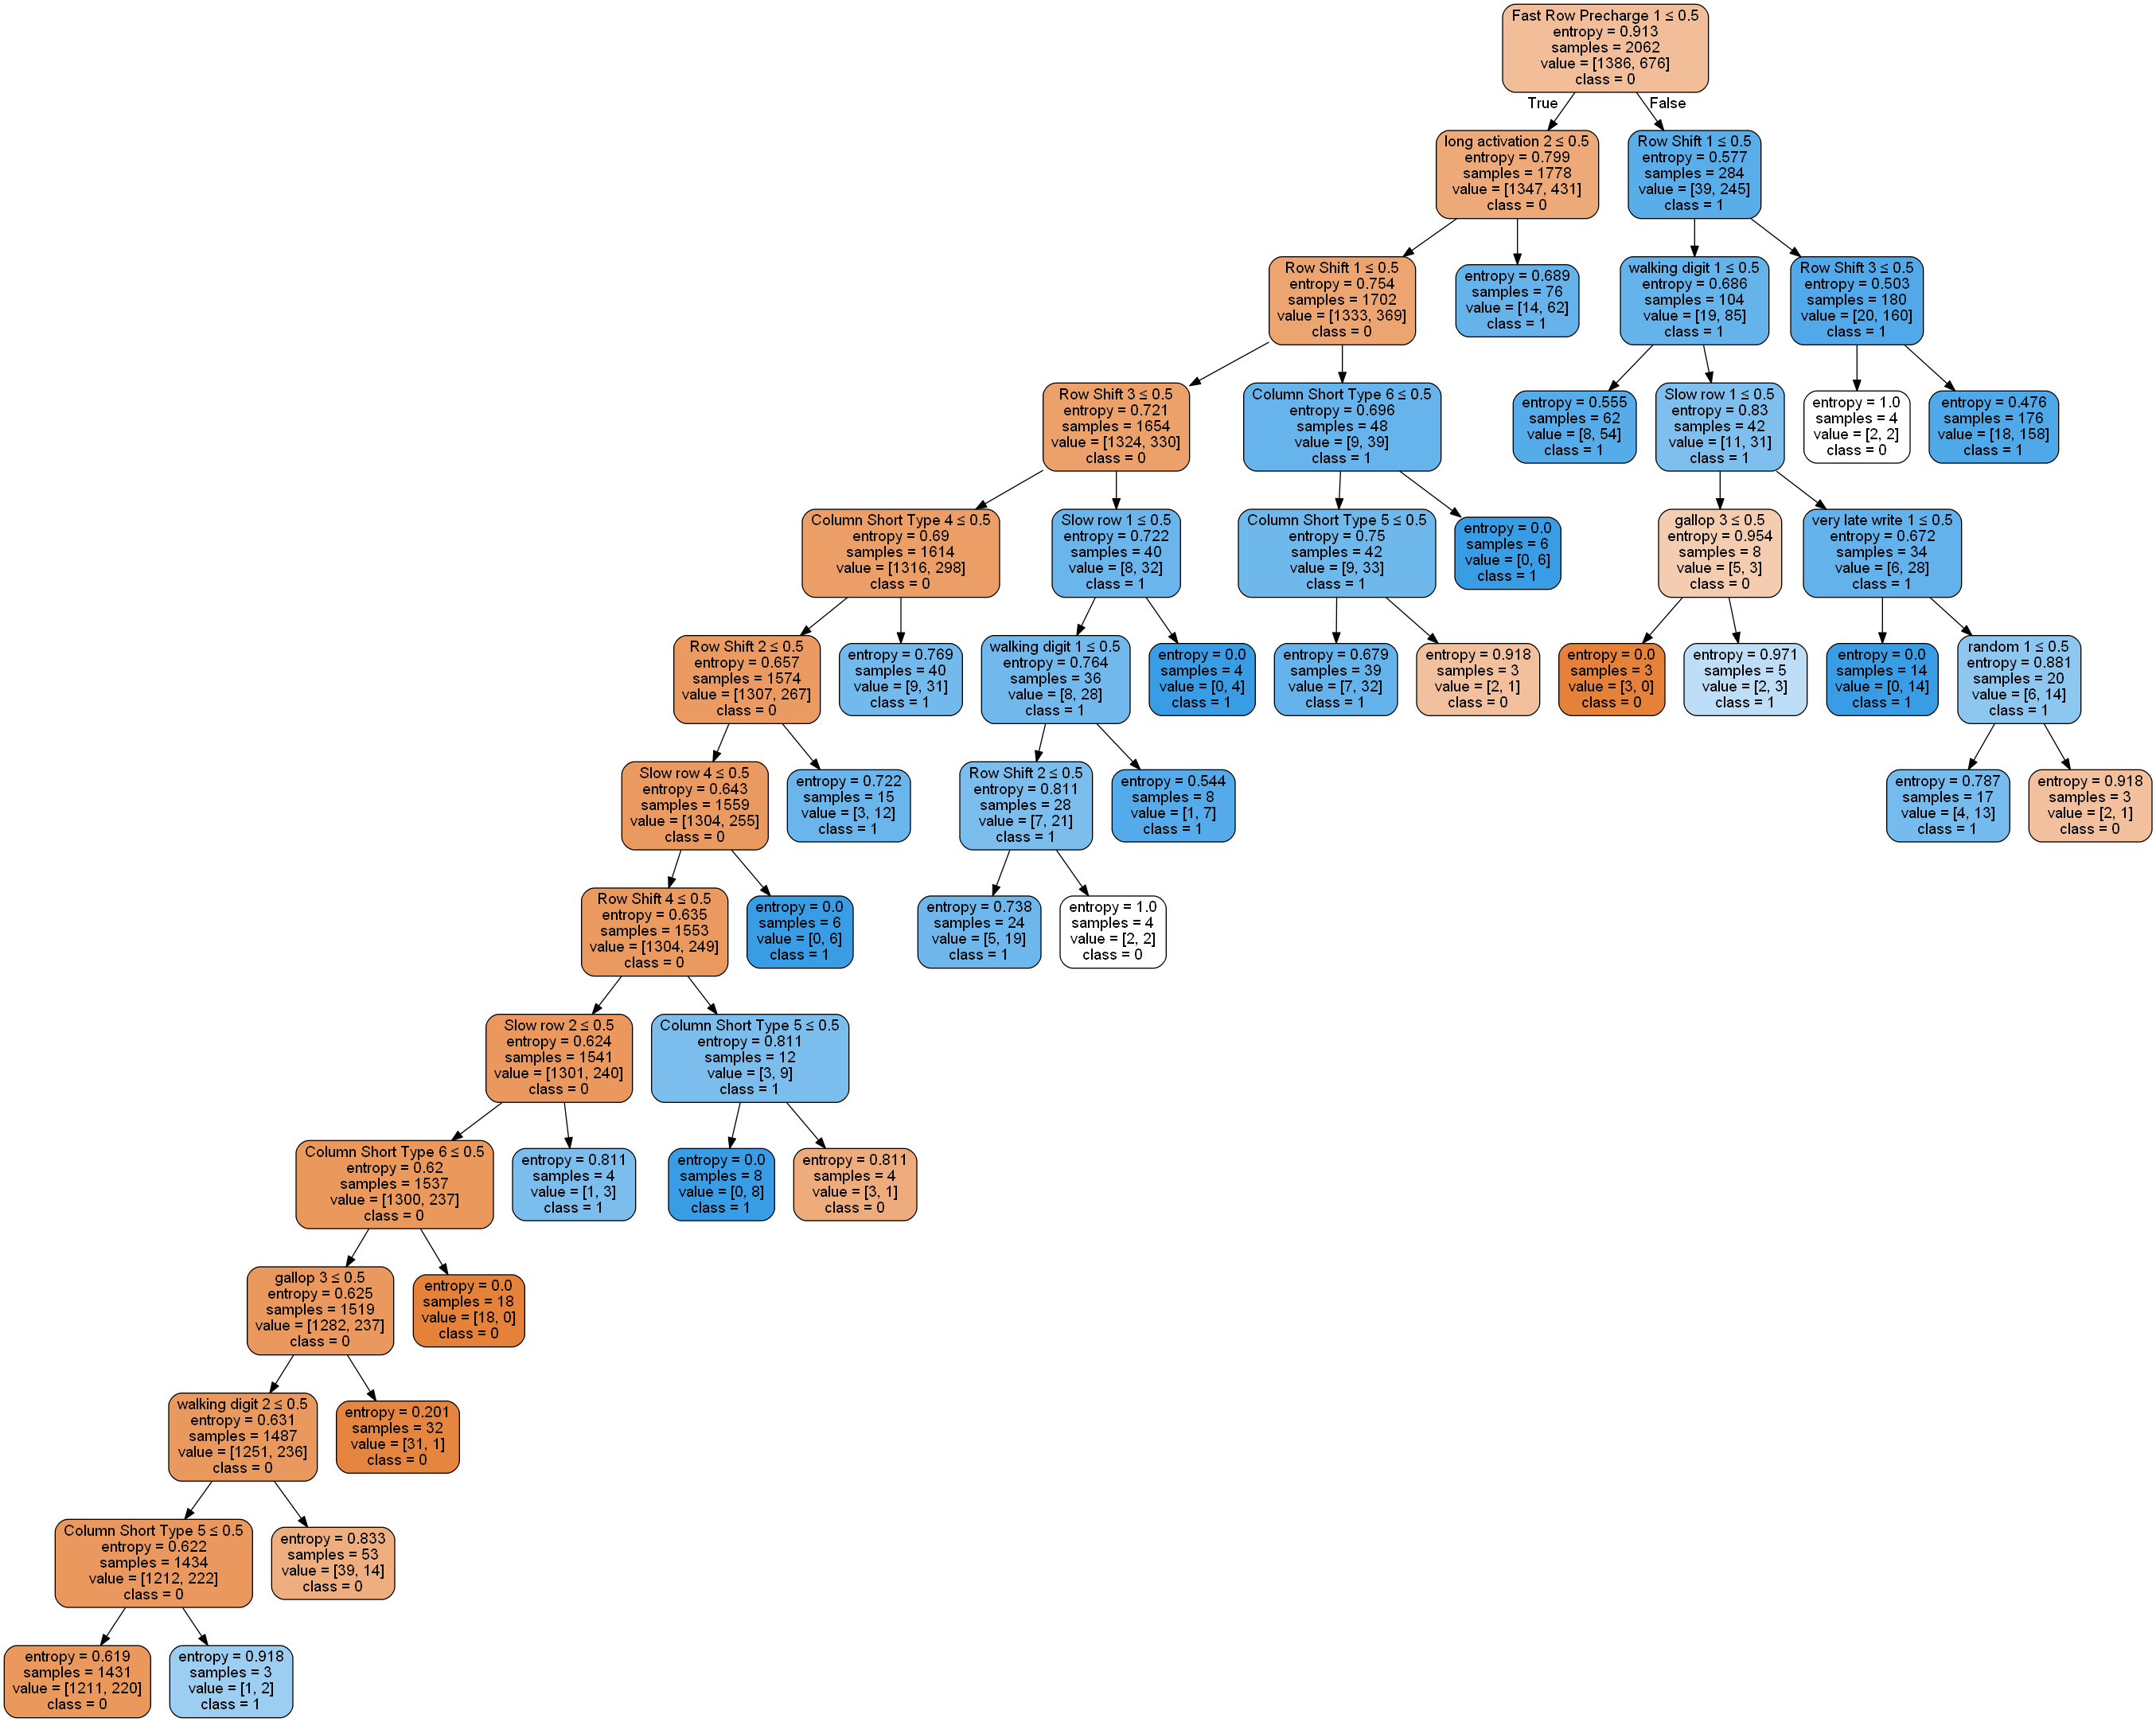

In [53]:
#DT visualizatin method 3
#!conda install -y pydotplus
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
#os.environ["PATH"] += os.pathsep + 'C:/Users/boonping/graphviz-2.38/release/bin'

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('testClassified.png')
Image(graph.create_png())

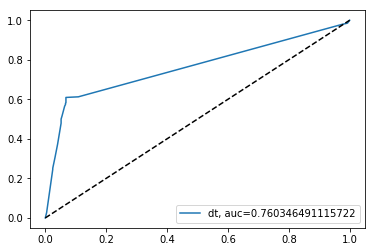

In [54]:
from sklearn import metrics

y_pred_proba = dt.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

plt.plot(fpr,tpr,label="dt, auc="+str(auc))
plt.plot([0,1],[0,1],'k--')
plt.legend(loc=4)
plt.show()

In [55]:
print(dt.feature_importances_)
#print(sorted(dt.feature_importances_))

ranked_feature=[]
for i in range(58):
    ranked_feature.append('')
sorted_importance=sorted(dt.feature_importances_)
for i in range( len(dt.feature_importances_) ):
    if dt.feature_importances_[i]>0.20*sorted_importance[-1] or sorted_importance.index(dt.feature_importances_[i]) > len(dt.feature_importances_)-best_depth-1:
        #print(i)
        ranked_feature[57-sorted_importance.index(dt.feature_importances_[i])]=test_data.columns[i+1]
        
for f in ranked_feature:
    if f != "":
        print(f)
    

[0.         0.         0.         0.46199445 0.09306486 0.
 0.00812766 0.00887882 0.         0.         0.         0.00395213
 0.00446376 0.         0.         0.00787202 0.         0.13123148
 0.         0.0763839  0.         0.         0.         0.
 0.01038585 0.03414878 0.08160467 0.00231421 0.02447877 0.
 0.01804859 0.         0.         0.         0.         0.02324498
 0.         0.         0.         0.00980508 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]
Fast Row Precharge 1
long activation 2
Row Shift 1
Row Shift 3
Column Short Type 4
Row Shift 2
Slow row 4
Row Shift 4
Column Short Type 5
gallop 3
Column Short Type 6
Slow row 1
very late write 1


In [56]:
#multi-class

#X = test_data.drop(["ID","SB","COL","Margin","Block","ROW"],axis = 1)
y = test_data.SB+test_data.COL+test_data.ROW

#importing train_test_split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=1/3,random_state=2, stratify=y)

from sklearn.tree import DecisionTreeClassifier

max_accuracy=0
best_depth=12
best_impurity_decrease=0.0001
best_weight_fraction_leaf=0.001
for DEPTH in range(12,21,1):
    dt = DecisionTreeClassifier(criterion='entropy',max_depth=DEPTH,random_state=0,min_impurity_decrease=0.0001,min_weight_fraction_leaf=0.001)
    dt.fit(X_train, y_train)
    #post_pruning
    prune_duplicate_leaves(dt)

    print(DEPTH,dt.score(X_test, y_test))
    if dt.score(X_test, y_test)>max_accuracy: 
        max_accuracy=dt.score(X_test, y_test)
        best_depth=DEPTH
        
for impurity_decrease in range(5,15,1):

    dt = DecisionTreeClassifier(criterion='entropy',max_depth=best_depth,random_state=0,min_impurity_decrease=impurity_decrease*0.00001,min_weight_fraction_leaf=0.001)
    dt.fit(X_train, y_train)
    #post_pruning
    prune_duplicate_leaves(dt)

    print(best_depth,impurity_decrease,dt.score(X_test, y_test))
    if dt.score(X_test, y_test)>max_accuracy: 
        max_accuracy=dt.score(X_test, y_test)
        best_impurity_decrease=impurity_decrease*0.00001
        
for weight_fraction_leaf in range(5,15,1):
    dt = DecisionTreeClassifier(criterion='entropy',max_depth=best_depth,random_state=0,min_impurity_decrease=best_impurity_decrease,min_weight_fraction_leaf=weight_fraction_leaf*0.0001)
    dt.fit(X_train, y_train)
    #post_pruning
    prune_duplicate_leaves(dt)

    print(best_depth,best_impurity_decrease,weight_fraction_leaf,dt.score(X_test, y_test))
    if dt.score(X_test, y_test)>max_accuracy: 
        max_accuracy=dt.score(X_test, y_test)
        best_weight_fraction_leaf=weight_fraction_leaf*0.0001

        
    

dt = DecisionTreeClassifier(criterion='entropy',max_depth=best_depth,random_state=0,min_impurity_decrease=best_impurity_decrease,min_weight_fraction_leaf=best_weight_fraction_leaf)
dt.fit(X_train, y_train)    

#post_pruning
prune_duplicate_leaves(dt)

print("selected depth: {:d}".format(best_depth))
print("selected best_impurity_decrease: {:.8f}".format(best_impurity_decrease))
print("selected best_weight_fraction_leaf: {:.8f}".format(best_weight_fraction_leaf))
print("Accuracy on training set: {:.3f}".format(dt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(dt.score(X_test, y_test)))

12 0.6100872938894277
13 0.6100872938894277
14 0.6081474296799224
15 0.6042677012609118
16 0.6081474296799224
17 0.6081474296799224
18 0.6110572259941804
19 0.6110572259941804
20 0.6129970902036858
20 5 0.6129970902036858
20 6 0.6129970902036858
20 7 0.6129970902036858
20 8 0.6129970902036858
20 9 0.6129970902036858
20 10 0.6129970902036858
20 11 0.6129970902036858
20 12 0.6129970902036858
20 13 0.6129970902036858
20 14 0.6129970902036858
20 0.0001 5 0.6091173617846751
20 0.0001 6 0.6091173617846751
20 0.0001 7 0.6091173617846751
20 0.0001 8 0.6091173617846751
20 0.0001 9 0.6091173617846751
20 0.0001 10 0.6129970902036858
20 0.0001 11 0.6129970902036858
20 0.0001 12 0.6129970902036858
20 0.0001 13 0.6110572259941804
20 0.0001 14 0.6110572259941804
selected depth: 20
selected best_impurity_decrease: 0.00010000
selected best_weight_fraction_leaf: 0.00100000
Accuracy on training set: 0.629
Accuracy on test set: 0.613


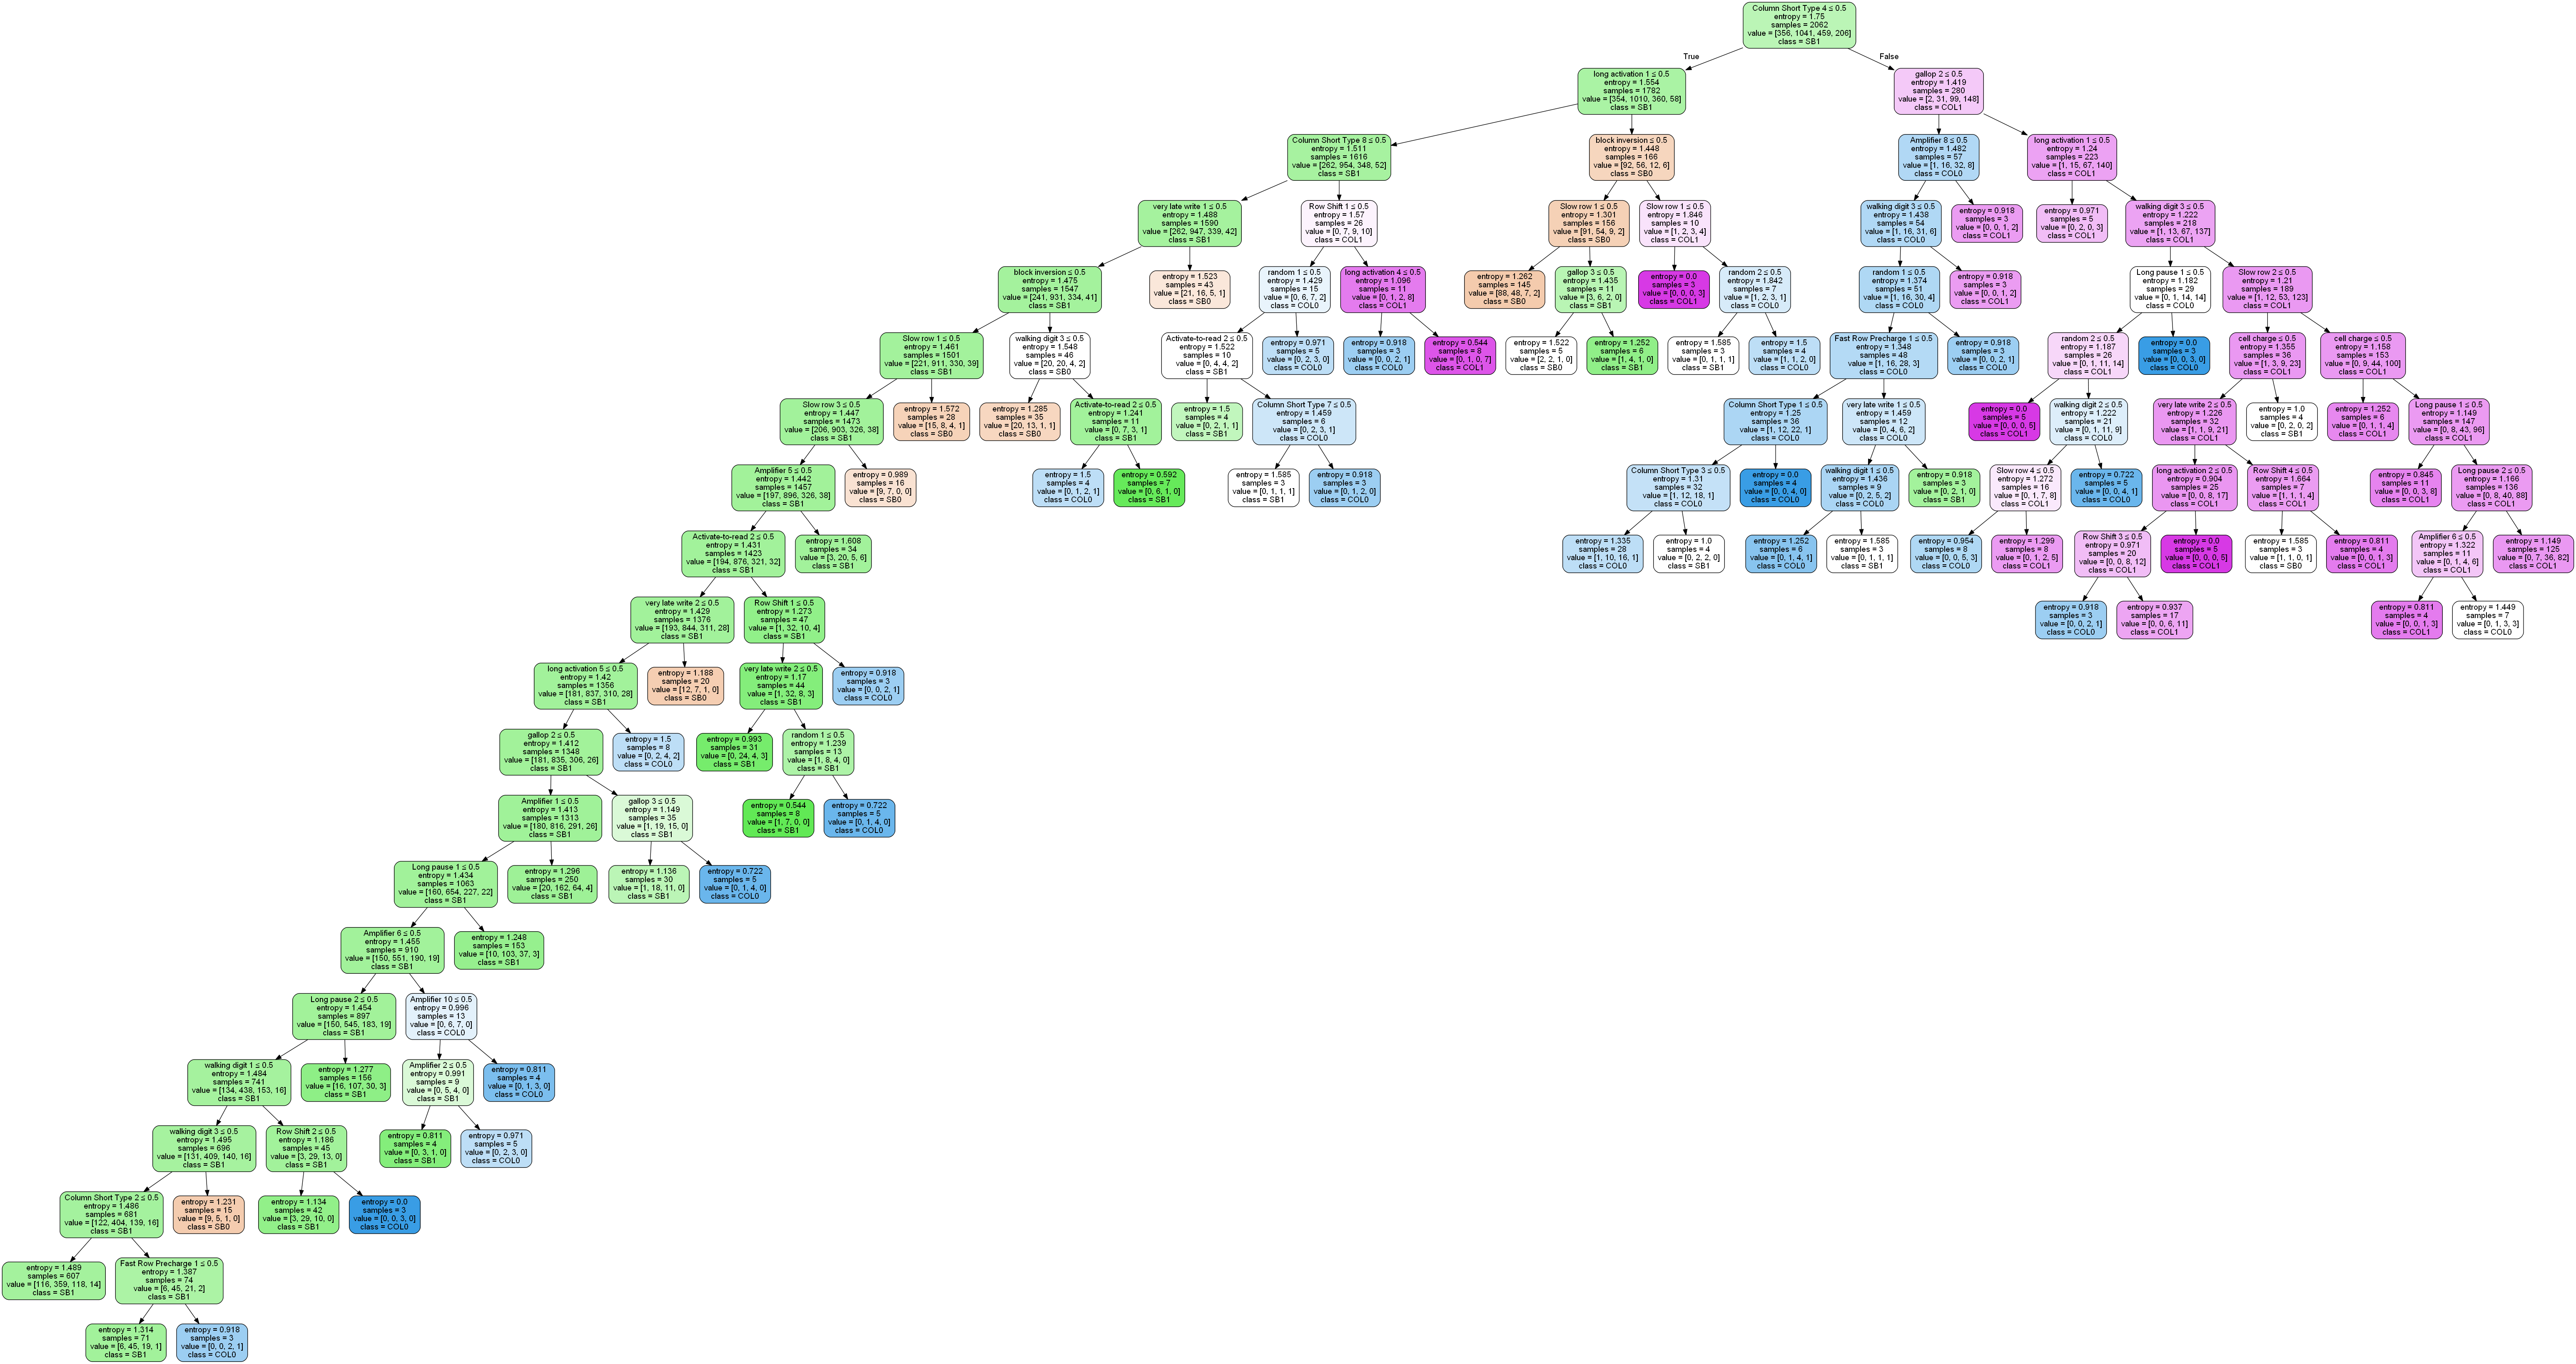

In [57]:
#DT visualizatin method 3
#!conda install -y pydotplus
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
#os.environ["PATH"] += os.pathsep + 'C:/Users/boonping/graphviz-2.38/release/bin'

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X.columns,class_names=['SB0','SB1','COL0','COL1','ROW0','ROW1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('testClassified.png')
Image(graph.create_png())

In [58]:
#multi-class decision tree
y_pred = dt.predict(X_test)
from sklearn.metrics import classification_report, confusion_matrix  

print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred)) 

[[ 89  87   2   0]
 [ 55 443  17   5]
 [  9 160  32  29]
 [  4  12  19  68]]
              precision    recall  f1-score   support

           0       0.57      0.50      0.53       178
           1       0.63      0.85      0.73       520
           2       0.46      0.14      0.21       230
           3       0.67      0.66      0.66       103

   micro avg       0.61      0.61      0.61      1031
   macro avg       0.58      0.54      0.53      1031
weighted avg       0.58      0.61      0.57      1031



In [59]:
print(dt.feature_importances_)
#print(sorted(dt.feature_importances_))

ranked_feature=[]
for i in range(58):
    ranked_feature.append('')
sorted_importance=sorted(dt.feature_importances_)
for i in range( len(dt.feature_importances_) ):
    if dt.feature_importances_[i]>0.20*sorted_importance[-1] or sorted_importance.index(dt.feature_importances_[i]) > len(dt.feature_importances_)-best_depth-1:
        #print(i)
        ranked_feature[57-sorted_importance.index(dt.feature_importances_[i])]=test_data.columns[i+1]
        
for f in ranked_feature:
    if f != "":
        print(f)
    

[0.00686923 0.09927659 0.         0.00939772 0.01382328 0.00327616
 0.02135798 0.0294409  0.00607066 0.01408271 0.         0.00696538
 0.00181234 0.00057137 0.00810562 0.00287597 0.00608957 0.00340649
 0.04747819 0.47062622 0.         0.01587248 0.03836358 0.0326087
 0.00339166 0.00616017 0.00079092 0.01295145 0.00247991 0.
 0.         0.02908647 0.         0.00087531 0.         0.00389865
 0.00783774 0.01399421 0.         0.         0.         0.01169356
 0.         0.00904943 0.         0.00132939 0.         0.
 0.00528544 0.         0.00431964 0.00983992 0.03781256 0.
 0.         0.00083244 0.         0.        ]
Column Short Type 4
long activation 1
gallop 2
block inversion
Column Short Type 8
walking digit 3
Slow row 1
very late write 2
very late write 1
Slow row 3
Long pause 1
Activate-to-read 2
Row Shift 1
random 1
Amplifier 5
long activation 5
Fast Row Precharge 1
Amplifier 6
Amplifier 1
random 2


In [60]:
scaler = StandardScaler()  
scaler.fit(X_train)

X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)  

from sklearn.neural_network import MLPClassifier  
mlp = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000,verbose=2)  
mlp.fit(X_train, y_train)  

predictions = mlp.predict(X_test)  


print("Accuracy", metrics.accuracy_score(y_test, predictions))
print(confusion_matrix(y_test,predictions))  
print(classification_report(y_test,predictions))  
print(mlp.coefs_[0][1])

Iteration 1, loss = 2.20100227
Iteration 2, loss = 2.06754869
Iteration 3, loss = 1.97097725
Iteration 4, loss = 1.89557402
Iteration 5, loss = 1.83479219
Iteration 6, loss = 1.78024406
Iteration 7, loss = 1.72636729
Iteration 8, loss = 1.67378570
Iteration 9, loss = 1.61825248
Iteration 10, loss = 1.55986817
Iteration 11, loss = 1.49804582
Iteration 12, loss = 1.43317257
Iteration 13, loss = 1.36830068
Iteration 14, loss = 1.30402397
Iteration 15, loss = 1.24164324
Iteration 16, loss = 1.19088346
Iteration 17, loss = 1.15007829
Iteration 18, loss = 1.11807976
Iteration 19, loss = 1.09438654
Iteration 20, loss = 1.07730041
Iteration 21, loss = 1.06329767
Iteration 22, loss = 1.05291736
Iteration 23, loss = 1.04413706
Iteration 24, loss = 1.03581869
Iteration 25, loss = 1.02820179
Iteration 26, loss = 1.02190336
Iteration 27, loss = 1.01647575
Iteration 28, loss = 1.01111887
Iteration 29, loss = 1.00671533
Iteration 30, loss = 1.00436092
Iteration 31, loss = 1.00108059
Iteration 32, los

Iteration 271, loss = 0.87866452
Iteration 272, loss = 0.87921546
Iteration 273, loss = 0.87966867
Iteration 274, loss = 0.87920464
Iteration 275, loss = 0.87797264
Iteration 276, loss = 0.87744221
Iteration 277, loss = 0.87726382
Iteration 278, loss = 0.87800241
Iteration 279, loss = 0.87732964
Iteration 280, loss = 0.87779997
Iteration 281, loss = 0.87804442
Iteration 282, loss = 0.87691426
Iteration 283, loss = 0.87809958
Iteration 284, loss = 0.87674042
Iteration 285, loss = 0.87608618
Iteration 286, loss = 0.87728981
Iteration 287, loss = 0.87619256
Iteration 288, loss = 0.87609062
Iteration 289, loss = 0.87572085
Iteration 290, loss = 0.87590577
Iteration 291, loss = 0.87492319
Iteration 292, loss = 0.87600059
Iteration 293, loss = 0.87531766
Iteration 294, loss = 0.87494349
Iteration 295, loss = 0.87496673
Iteration 296, loss = 0.87732850
Iteration 297, loss = 0.87632234
Iteration 298, loss = 0.87458425
Iteration 299, loss = 0.87504374
Iteration 300, loss = 0.87542463
Iteration 

In [61]:


feature={}
node_feature=[]

for l in range(10):
    min_weight=mlp.coefs_[0][0:][l].min()
    max_weight=mlp.coefs_[0][0:][l].max()
    if abs(min_weight)>abs(max_weight): max_weight=abs(min_weight)
    max_weight=abs(max_weight)
    for i in range(58):
        weight = mlp.coefs_[0][i][l]
        if weight>0 and weight/max_weight>0.33: 
            if test_data.columns[i+1] not in feature: 
                feature[ test_data.columns[i+1] ]=0
            feature[ test_data.columns[i+1] ]+=1
            node_feature.append(test_data.columns[i+1])
        #elif weight<0 and weight/max_weight>0.33: 
            #if test_data.columns[i+1] not in feature: 
            #    feature[ test_data.columns[i+1] ]=0
            #feature[ test_data.columns[i+1] ]+=1
            #node_feature.append(test_data.columns[i+1])
    #print(node_feature)
    #node_feature=[]
        
#for f in feature: 
#    if feature[f]>5: print(f)
        
    
    

In [62]:
featurelist=[]
feature_freq=[]
notfeature_freq=[]
for testnum in range(58):
    featurelist.append( test_data.columns[testnum+1] )
    feature_freq.append(0)
    notfeature_freq.append(0)

for i in range(len(X_test)):
    if predictions[i]==1:
        total_ones=0
        total_zeros=0
        for testnum in range(58):
            if X_test[i][testnum]>=0.45: #if transformed X is greater than 0.5
                total_ones+=1
            else:
                total_zeros+=1
        
        for testnum in range(58):
            if X_test[i][testnum]>=0.45: #if transformed X is greater than 0.5
                feature_freq[testnum]+=1/total_ones
            else:
                notfeature_freq[testnum]+=1/total_zeros
                
#print (X_test[0])
sorted_featurelist=[]
sorted_notfeaturelist=[]
for i in range(58):
    sorted_featurelist.append([])
    sorted_notfeaturelist.append([])
sorted_freq=sorted( feature_freq )                
for i in range(len(feature_freq)):
    if feature_freq[i]>0.25*sorted_freq[-1] or sorted_freq.index( feature_freq[i] )>0.75*58:
        if feature_freq[i]>1.5*notfeature_freq[i]:
            sorted_featurelist[57-sorted_freq.index( feature_freq[i] )]=[featurelist[i],feature_freq[i],notfeature_freq[i]]
        
#positive,negative prediction frequency for selected features with significant importance
for f in sorted_featurelist:
    if f!=[]:
        print(f)    
        

['Amplifier 1', 121.0, 9.247851100565315]
['Long pause 1', 80.9621212121212, 9.881593476927847]
['Long pause 2', 76.71212121212122, 9.972459094910167]
['cell charge', 74.29077540106952, 9.961691463884977]
['Column Short Type 1', 34.52486631016043, 10.536434943622876]
['long activation 2', 34.18490418894831, 10.637047803451862]
['Column Short Type 2', 23.60819964349376, 10.707678269328447]
['Fast Row Precharge 1', 23.181116310160427, 10.724844699389616]
